# E1 Phase Analysis - Adjoint-Based Optimization

## Overview
This notebook simulates the EM field experienced by the elctron with varying pillar design parameters to map the feature space. 

## Key Components

### Physical Parameters
- **Wavelength**: 1.932 μm (laser wavelength)
- **Electron Velocity**: β = 0.4 (initial velocity)
- **Structure**: 52-period dual-pillar photonic crystal
- **Material**: Silicon (Si) with Palik refractive index

### Adjoint Method Implementation
1. **Forward Simulation**: Standard FDTD simulation with plane wave source
2. **Adjoint Simulation**: Reverse simulation with dipole-like source (electron field)
3. **Matrix Manipulation**: Linear algebra operations to compute gradients efficiently
4. **Gradient Calculation**: Computes ∂G/∂φ using electromagnetic field gradients
5. **Parameter Update**: Custom Adam optimizer with basin hopping for global optimization

### Optimization Strategy
- **Design Target**: Sinusoidal phase profile across 52 periods
- **Cost Function**: Minimize difference between achieved and target phase
- **Optimizer**: Custom Adam gradient descent with basin hopping for global search
- **Constraints**: Physical bounds on pillar dimensions and positions

### Key Functions
- `adjoint_source_calc()`: Calculates adjoint source phase distribution
- `func()`: Main optimization objective function
- `adam_optimize()`: Custom Adam implementation with basin hopping
- `build_structure()`: Constructs dual-pillar geometry in FDTD

### Computational Efficiency
The adjoint method reduces the number of required simulations from O(N²) to O(N) by using matrix manipulation to compute gradients efficiently, where N is the number of optimization parameters.

### Results
- Optimized pillar dimensions (rx, ry) and positions (y_pos)
- Phase profile matching target sinusoidal design
- Energy gain calculations for electron acceleration

## Usage
Run cells sequentially. The optimization will iterate through multiple random starting points using basin hopping to find global minimum. Results are saved to text files for further analysis.

In [ ]:
import sys, os
#sys.path.append("C:\\Program Files\\Lumerical\\v212\\api\\python\\") #Default windows lumapi path
import numpy as np
import matplotlib.pyplot as plt
#import lumapi
from scipy.fft import fft, ifft, fftfreq, fftshift
import scipy.optimize as so
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from numpy import unravel_index
from numpy import linalg as npla
from scipy.optimize import basinhopping
import random
from IPython.core.debugger import set_trace
import math
import time
import cmath
from scipy import interpolate
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit 
import pandas as pd 
import scipy.special as sp
from matplotlib import pylab
from pylab import figure, text, scatter, show
from scipy import stats
from pylab import *
import scipy.interpolate
from scipy.signal import argrelextrema
from scipy.spatial import distance
import seaborn as sns
tfont = {'fontname':'Times New Roman'}

In [2]:
maxbetaarray = np.array([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8])
maxe1array = np.array([0.02997519, 0.08826858, 0.14586067, 0.18895123, 0.21824774, 0.23316292, 0.31697082, 0.43405189, 0.54406427, 0.76910321, 0.79951867, 0.85867393, 0.85867138, 0.81988915, 0.80016179 ])

In [3]:
Rampdf = pd.DataFrame(np.array(np.loadtxt("Final-ramp-bestGvals-300per-1.txt")))
Sindf = pd.DataFrame(np.array(np.loadtxt("Final-sinusoid-bestGvals-300per-1.txt")))
Sawdf = pd.DataFrame(np.array(np.loadtxt("Final-sawtooth-bestGvals-150per-1.txt")))
Superdf = pd.DataFrame(np.array(np.loadtxt("Final-superposition-bestGvals-150per-1.txt")))

In [4]:
lml = 1.932e-6 #laser wavelength
beta = 0.35 #electron velocity 
Periods = 300

beta_array = np.full((Periods,), beta) #array of electron velocity at each period
Periods_array = lml*beta_array #periodicity of each cell
preperarr = Periods_array.copy()
delta_W = np.zeros((Periods,1))
betaratio = np.ones(Periods)

c = 3e8 #speed of light 
f = c/lml #frequency
q = 1 #charge in e
m = 0.511e6 #mass in eV/c**2


max_Periods_array = Periods_array.copy()

In [5]:
def e1_scaling_sigmoid(desired_beta):
    energy_scaling = 0.1681616 + 0.71904549/(1+np.exp(-15.87927686*(desired_beta-0.48068445)))
    return energy_scaling *0.9

In [6]:
def accel_calc(period, EY):
    '''

    Takes in a periodicity array and array of e1 values and calculates energy and velocity and then 
    returns an updated periodicity array.  
    
    '''
    global delta_W
    global beta_array
    global W_array
    global betaratio
    W_array = np.full(Periods, ((1/(np.sqrt(1-beta**2)))-1)*m) #injection energy
    for j in range(Periods-1):
        #energy calculation from 6D tracking eq 7
        delta_W[j] = q*period[j]*np.real(EY[j]*np.exp(2*np.pi*1j*period[j]/max_Periods_array[j]))*100e6 #possibly need to add a phase term here   
        W_array[j+1] = W_array[j] + delta_W[j]
        #beta calculated from energy
        beta_array[j+1] =  np.sqrt(1-(1/((W_array[j+1]/m)+1))**2)
        betaratio[j+1] =  np.sqrt(1-(1/((W_array[j+1]/m)+1))**2)/np.sqrt(2/m * W_array[j+1])
        period[j+1] = lml*beta_array[j+1]
    #update the last element of the array
    delta_W[-1] = q*period[-1]*np.real(EY[-1]*np.exp(2*np.pi*1j*period[-1]/max_Periods_array[-1]))*100e6
    return period

In [7]:
RampGdf = pd.DataFrame(np.array(np.loadtxt("retvalarray_nonperiodic-ramp.txt")))
RampParamdf = pd.DataFrame(np.array(np.loadtxt("basinarray_nonperiodic-ramp.txt")))

SinGdf = pd.DataFrame(np.array(np.loadtxt("retvalarray_nonperiodic-sinusoid.txt")))
SinParamdf = pd.DataFrame(np.array(np.loadtxt("basinarray_nonperiodic-sinusoid.txt")))

SawGdf = pd.DataFrame(np.array(np.loadtxt("retvalarray_nonperiodic-sawtooth.txt")))
SawParamdf = pd.DataFrame(np.array(np.loadtxt("basinarray_nonperiodic-sawtooth.txt")))

SuperGdf = pd.DataFrame(np.array(np.loadtxt("retvalarray_nonperiodic-superposition.txt")))
SuperParamdf = pd.DataFrame(np.array(np.loadtxt("basinarray_nonperiodic-superposition.txt")))

In [8]:
Periods = 300 
H = 2
L = 15
beta = 0.35 
betaratio = np.ones(Periods)
beta_array = np.full((Periods,), beta) #array of electron velocity at each period
Periods_array = lml*beta_array #periodicity of each cell
max_Periods_array = Periods_array.copy()

a = np.linspace(0,np.pi,Periods)
z = (np.cos(a) + 16)/15 #*(m/2*beta**2)
d_n = np.flip(np.reshape(z,(Periods,1)))
Barray = np.sqrt(1-(1/((d_n/m)+1))**2)
d_n = e1_scaling_sigmoid(Barray)

max_Periods_array = accel_calc(max_Periods_array, d_n.flatten()) #calculate the max_Periods from the design curve
FDTDxspan = 4.2e-6
FDTDyspan = np.sum(max_Periods_array)
FDTDdx = 10.0e-9
FDTDdy = 10.0e-9
yarrsize = math.ceil(max_Periods_array[-1]/FDTDdy) #max array size to interpolate all cells to, for numpy array operations
xarrsize = math.ceil(FDTDxspan/(2*FDTDdx)) + 1
cell_size = yarrsize//Periods
Xmax = np.linspace(0.0, FDTDxspan/2, xarrsize)
Ymax = np.linspace(0.0, FDTDyspan, yarrsize)
#max_Periods_array
FDTDyspan*1e6, W_array[0]/1000, W_array[-1]/W_array[0]

(206.9209850011047, 34.50324396266351, 1.090648991843586)

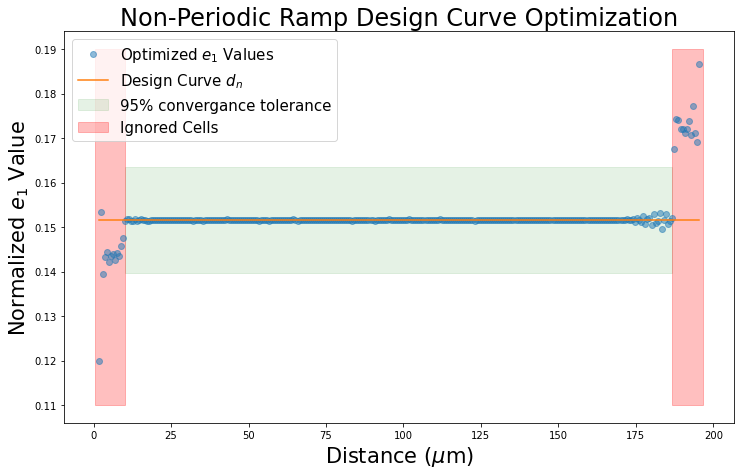

In [9]:
B = RampParamdf.loc[RampGdf.idxmin()]
X = B[B.columns[2::3]].to_numpy().flatten()*1e6*betaratio
Y = Rampdf.to_numpy().flatten()
Ydep = Y

kernel_size = 30
kernel = np.ones(kernel_size) / kernel_size
G_conv = np.convolve(Ydep, kernel, mode='same')
G_conv[0] = np.sum(Ydep[:2])/2
G_conv[-1] = np.sum(Ydep[-2:])/2
G = G_conv.copy()

plt.plot(X[H:Periods-H], Ydep[H:Periods-H], 'o', alpha=0.5, label='Optimized $e_1$ Values')
plt.plot(X[H:Periods-H], d_n[H:Periods-H], label='Design Curve $d_n$')
#plt.plot(X[2*L:Periods-2*L], G[2*L:-2*L], color='r', label='Averaged $e_1$ Values')
plt.fill_between(X[L:Periods-L], d_n[L:Periods-L].flatten()-np.round((5.1*maxe1array[maxbetaarray==beta])/100, 4),
                 d_n[L:Periods-L].flatten()+np.round((5.1*maxe1array[maxbetaarray==beta])/100, 4), alpha=0.1,
                 label='95% convergance tolerance', color='g')
plt.fill_between(X[:L+1], 0.11, 0.19, alpha=0.25, color='r', label='Ignored Cells')
plt.fill_between(X[-(L+1):], 0.11, 0.19, alpha=0.25, color='r')

#plt.plot(x,y, 'm', label='Hg Full Spectrum')

#plt.text(4437, 0.041, '4437 A', rotation=0, ha='center')
#plt.text(4912, 0.13, '4912 A', rotation=0, ha='center')
#plt.text(6466, 0.0175, '6466 A', rotation=0, ha='center')


plt.title('Non-Periodic Ramp Design Curve Optimization', fontsize=24)
plt.xlabel('Distance ($\mu$m)', fontsize=21)
plt.ylabel('Normalized $e_1$ Value', fontsize=21)
#for j in range(Periods):
#    plt.axvline(x=np.sum(max_Periods_array[:j])*1e6, ymin=0.2, ymax=0.5, color='k', linestyle=':')
    #print(max_Periods_array[j])
#plt.axvline(x=4702, ymax=.25, color='b', linestyle='--')
#plt.axvline(x=4912, ymax=.95, color='b', linestyle='--')
#plt.axvline(x=6466, ymax=.11, color='b', linestyle='--')

#plt.fill_between(X[H:Periods-H], d_n[H:Periods-H].flatten()-0.01, d_n[H:Periods-H].flatten()+0.01 ,alpha=0.1, 
                # label='99% convergance tolerance', color='g')

plt.legend(loc='upper left', fontsize=15)


#from pylab import figure, text, scatter, show
#plt.autoscale(enable=True, axis='x')
#plt.text(0.027,9.5,'60.0 Hz')
#plt.legend()

#plt.savefig('IVcurvemultiplot.svg', bbox_inches='tight')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 7.2, forward=True)

#plt.savefig('NPRampCurve.pdf', format='pdf', bbox_inches='tight')

In [10]:
Periods = 300 
L = 15
H = 0
beta = 0.35 
betaratio = np.ones(Periods)
beta_array = np.full((Periods,), beta) #array of electron velocity at each period
Periods_array = lml*beta_array #periodicity of each cell
max_Periods_array = Periods_array.copy()

a = np.linspace(0,2*np.pi,Periods)
z = 1/((np.cos(a)+20)/30) - 1.428#*(m/2*beta**2)
d_n = np.flip(np.reshape(z,(Periods,1)))

max_Periods_array = accel_calc(max_Periods_array, d_n.flatten()) #calculate the max_Periods from the design curve
FDTDxspan = 4.2e-6
FDTDyspan = np.sum(max_Periods_array)
FDTDdx = 10.0e-9
FDTDdy = 10.0e-9
yarrsize = math.ceil(max_Periods_array[-1]/FDTDdy) #max array size to interpolate all cells to, for numpy array operations
xarrsize = math.ceil(FDTDxspan/(2*FDTDdx)) + 1
cell_size = yarrsize//Periods
Xmax = np.linspace(0.0, FDTDxspan/2, xarrsize)
Ymax = np.linspace(0.0, FDTDyspan, yarrsize)
FDTDyspan*1e6, W_array[0]/1000, W_array[-1]/W_array[0]

(204.83633282967762, 34.50324396266351, 1.0437129407133618)

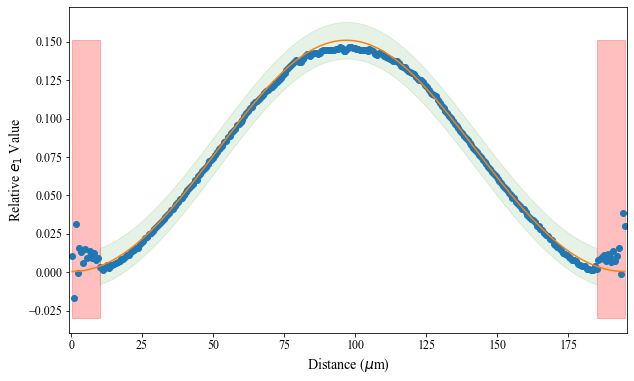

In [11]:
B = SinParamdf.loc[SinGdf.idxmin()]
X = B[B.columns[2::3]].to_numpy().flatten()*1e6*betaratio
Y = Sindf.to_numpy().flatten()


plt.plot(X[H:Periods-H], Y[H:Periods-H], 'o', label='Optimized $e_1$ Values')
plt.plot(X[H:Periods-H], d_n[H:Periods-H], label='Design Curve $d_n$')
plt.fill_between(X[L:Periods-L], d_n[L:Periods-L].flatten()-np.round((5.1*maxe1array[maxbetaarray==beta])/100, 4),
                 d_n[L:Periods-L].flatten()+np.round((5.1*maxe1array[maxbetaarray==beta])/100, 4), alpha=0.1,
                 label='95% convergance tolerance', color='g')
plt.fill_between(X[:L+1], np.where(Y < 0, Y, -Y*100).argmax()/(-100), np.max(d_n), alpha=0.25, color='r', label='Ignored Cells')
plt.fill_between(X[-(L+1):], np.where(Y < 0, Y, -Y*100).argmax()/(-100), np.max(d_n), alpha=0.25, color='r')


#plt.title('Non-Periodic Sinusoid Design Curve Optimization', fontsize=20)
plt.xlabel('Distance ($\mu$m)', fontsize=14, **tfont)
plt.ylabel('Relative $e_1$ Value', fontsize=14, **tfont)

plt.margins(x=0.005, tight=True)
plt.xticks(fontsize=12, **tfont)
plt.yticks(fontsize=12, **tfont)

#plt.legend(loc='lower center', fontsize=12)


fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6, forward=True)


plt.savefig('NPSinCurve-paper.png', format='png', bbox_inches='tight')

In [12]:
Periods = 150 
L = 15
H = 0
beta = 0.35
betaratio = np.ones(Periods)
beta_array = np.full((Periods,), beta) #array of electron velocity at each period
Periods_array = lml*beta_array #periodicity of each cell
max_Periods_array = Periods_array.copy()

a = np.linspace(0,3*np.pi,Periods)
z = (signal.sawtooth(2*a, width=0.25) + 1)/15 
d_n = np.flip(np.reshape(z,(Periods,1))) 

max_Periods_array = accel_calc(max_Periods_array, d_n.flatten()) #calculate the max_Periods from the design curve
FDTDxspan = 4.2e-6
FDTDyspan = np.sum(max_Periods_array)
FDTDdx = 10.0e-9
FDTDdy = 10.0e-9
yarrsize = math.ceil(max_Periods_array[-1]/FDTDdy) #max array size to interpolate all cells to, for numpy array operations
xarrsize = math.ceil(FDTDxspan/(2*FDTDdx)) + 1
cell_size = yarrsize//Periods
Xmax = np.linspace(0.0, FDTDxspan/2, xarrsize)
Ymax = np.linspace(0.0, FDTDyspan, yarrsize)
FDTDyspan*1e6, W_array[0]/1000, W_array[-1]/W_array[0]

(101.8491468084531, 34.50324396266351, 1.0195515971241471)

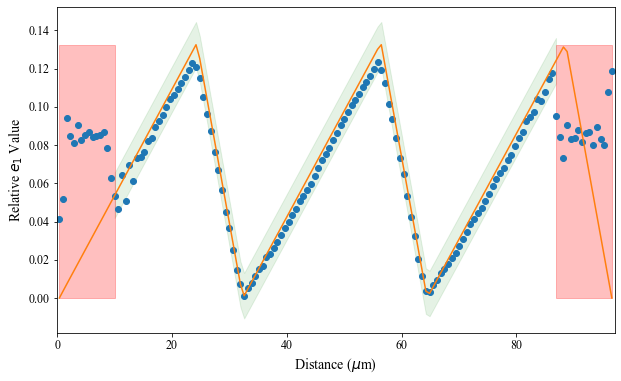

In [13]:
B = SawParamdf.loc[SawGdf.idxmin()]
X = B[B.columns[2::3]].to_numpy().flatten()*1e6*betaratio
Y = Sawdf.to_numpy().flatten()

plt.plot(X[H:Periods-H], Y[H:Periods-H], 'o', label='Optimized $e_1$ Values')
plt.plot(X[H:Periods-H], d_n[H:Periods-H], label='Design Curve $d_n$')
plt.fill_between(X[L:Periods-L], d_n[L:Periods-L].flatten()-np.round((5.1*maxe1array[maxbetaarray==beta])/100, 4),
                 d_n[L:Periods-L].flatten()+np.round((5.1*maxe1array[maxbetaarray==beta])/100, 4), alpha=0.1,
                 label='95% convergance tolerance', color='g')
plt.fill_between(X[:L+1], np.min(d_n), np.max(d_n), alpha=0.25, color='r', label='Ignored Cells')
plt.fill_between(X[-(L+1):], np.min(d_n), np.max(d_n), alpha=0.25, color='r')


#plt.title('Non-Periodic Sawtooth Design Curve Optimization', fontsize=20)
plt.xlabel('Distance ($\mu$m)', fontsize=14, **tfont)
plt.ylabel('Relative $e_1$ Value', fontsize=14, **tfont)

plt.margins(x=0.005, tight=True)
plt.xticks(fontsize=12, **tfont)
plt.yticks(fontsize=12, **tfont)


#plt.legend(loc='lower right', fontsize=12)


fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6, forward=True)

plt.savefig('NPSawtoothCurve-paper.png', format='png', bbox_inches='tight')

In [14]:
Periods = 150 
H = 2
L = 10
beta = 0.4
betaratio = np.ones(Periods)
beta_array = np.full((Periods,), beta) #array of electron velocity at each period
Periods_array = lml*beta_array #periodicity of each cell
max_Periods_array = Periods_array.copy()

a = np.linspace(0,2*np.pi,Periods)
z = (np.cos(3*a))/45 + np.cos(a)/45 + np.cos(5*a)/50 + np.cos(2*a)/40 + 0.05
d_n = np.flip(np.reshape(z,(Periods,1)))

max_Periods_array = accel_calc(max_Periods_array, d_n.flatten()) #calculate the max_Periods from the design curve
FDTDxspan = 4.2e-6
FDTDyspan = np.sum(max_Periods_array)
FDTDdx = 10.0e-9
FDTDdy = 10.0e-9
yarrsize = math.ceil(max_Periods_array[-1]/FDTDdy) #max array size to interpolate all cells to, for numpy array operations
xarrsize = math.ceil(FDTDxspan/(2*FDTDdx)) + 1
cell_size = yarrsize//Periods
Xmax = np.linspace(0.0, FDTDxspan/2, xarrsize)
Ymax = np.linspace(0.0, FDTDyspan, yarrsize)
FDTDyspan*1e6, W_array[0]/1000, W_array[-1]/W_array[0]

(116.23765224873083, 46.546709552960486, 1.0124021718710576)

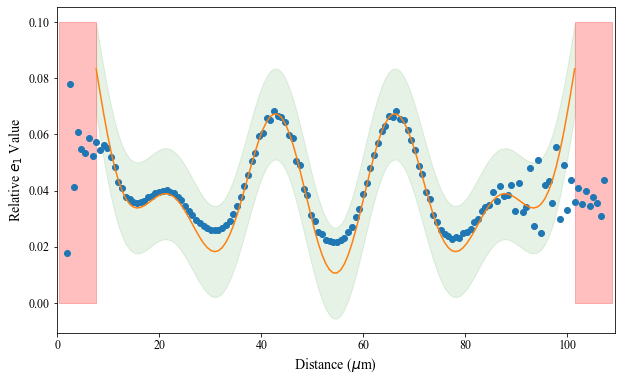

In [15]:
B = SuperParamdf.loc[SuperGdf.idxmin()]
X = B[B.columns[2::3]].to_numpy().flatten()*1e6*betaratio
Y = Superdf.to_numpy().flatten()

plt.plot(X[H:Periods-H], Y[H:Periods-H], 'o', label='Optimized $e_1$ Values')
plt.plot(X[L:Periods-L], d_n[L:Periods-L], label='Design Curve $d_n$')
plt.fill_between(X[L:Periods-L], d_n[L:Periods-L].flatten()-np.round((5.1*maxe1array[maxbetaarray==beta])/100, 4),
                 d_n[L:Periods-L].flatten()+np.round((5.1*maxe1array[maxbetaarray==beta])/100, 4), alpha=0.1,
                 label='95% convergance tolerance', color='g')
plt.fill_between(X[:L+1], 0, 0.1, alpha=0.25, color='r', label='Ignored Cells')
plt.fill_between(X[-(L+1):], 0, 0.1, alpha=0.25, color='r')



#plt.title('Non-Periodic Super-position Design Curve Optimization', fontsize=20)
plt.xlabel('Distance ($\mu$m)', fontsize=14, **tfont)
plt.ylabel('Relative $e_1$ Value', fontsize=14, **tfont)

plt.margins(x=0.005, tight=True)
plt.xticks(fontsize=12, **tfont)
plt.yticks(fontsize=12, **tfont)

#plt.legend(loc='upper center', fontsize=12)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6, forward=True)

plt.savefig('NPsuperpositionCurve-paper.png', format='png', bbox_inches='tight')

In [22]:
Phaserawdf = pd.DataFrame(np.array(np.loadtxt("Final-phase-52per-raw-1.txt")))
Phasesmoothdf = pd.DataFrame(np.array(np.loadtxt("Final-phase-52per-smooth-1.txt")))
PhaseGdf = pd.DataFrame(np.array(np.loadtxt("retvalarray_periodic-phase.txt")))
PhaseParamsdf = pd.DataFrame(np.array(np.loadtxt("basinarray_periodic_phase.txt")))

In [23]:
PhaseParamsdf.loc[PhaseGdf.idxmin()]

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
1,1.700000e-07,2.000000e-07,3.864000e-07,1.695413e-07,1.996663e-07,0.000001,1.688479e-07,1.991664e-07,0.000002,1.692369e-07,...,0.000022,1.692936e-07,1.994884e-07,0.000023,1.703245e-07,2.002410e-07,0.000024,1.700000e-07,2.000000e-07,0.000024


In [24]:
beta = 0.4
arr = []
for j in range(52):
    arr.append((j+1)*lml*beta/2)
arr = np.array(arr)

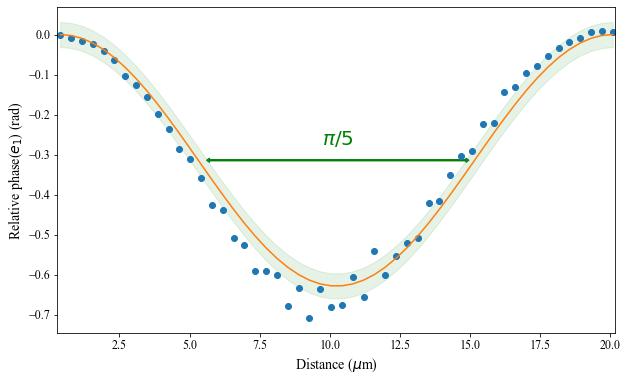

In [25]:
Periods = 52
beta = 0.4
H = 0
BR = 0.4/0.35

a = np.linspace(0,2*np.pi,Periods)
z = (np.cos(a))*np.pi/10 - np.pi/10
d_n = np.flip(np.reshape(z,(Periods,1)))

B = PhaseParamsdf.loc[PhaseGdf.idxmin()]
X = arr.copy()*1e6
Y = Phasesmoothdf.to_numpy().flatten()

plt.plot(X[H:Periods-H], Y, 'o', label='Optimized phase($e_1$) Values')
plt.plot(X[H:Periods-H], d_n[H:Periods-H], label='Design Curve $d_n$')
plt.arrow(5*BR, -0.314, 8*BR, 0, ec ='green', head_length=0.11, head_width=0.011, width=0.0025)
plt.arrow(13*BR, -0.314, -8*BR, 0, ec ='green', head_length=0.11, head_width=0.011, width=0.0025)
plt.text(8.5*BR, -0.275, '$\pi / 5$', fontsize = 20, color='g')

plt.fill_between(X[H:Periods-H], d_n[H:Periods-H].flatten()-0.0314, d_n[H:Periods-H].flatten()+0.0314 ,alpha=0.1, 
                 label='95% convergance tolerance', color='g')

#plt.title('Periodic Phase Shift Design Curve Optimization', fontsize=20)
plt.xlabel('Distance ($\mu$m)', fontsize=14, **tfont)
plt.ylabel('Relative phase($e_1$) (rad)', fontsize=14, **tfont)

plt.margins(x=0.005, tight=True)
plt.xticks(fontsize=12, **tfont)
plt.yticks(fontsize=12, **tfont)

#plt.legend(loc='lower right', fontsize=12)
#plt.ylabel('Relative $e_1$ Value', fontsize=18)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6, forward=True)

plt.savefig('PPhaseCurve-paper.png', format='png', bbox_inches='tight')

In [26]:
#plot period lines on small multipillar and non-periodic optimization

In [27]:
# single pillar optimization and brute force map
# phase vs ypos
# multi pillar optimization
# non-periodic optimization
# e1 vs periodicity 

In [28]:
e030 = pd.DataFrame(np.array(np.loadtxt("e1_array_030.txt")))
dfR = pd.DataFrame(np.array(np.loadtxt("R_array_030.txt")), columns=['Rx', 'Ry', 'ypos'])

In [29]:
dfR['e1'] = e030

In [30]:
dfR = dfR[(dfR.Ry <= 250e-9) & (dfR.Ry >= 100e-9)]

In [31]:
dfR = dfR[(dfR.Rx <= 250e-9) & (dfR.Rx >= 100e-9)]

In [32]:
dfR.drop(['ypos'], axis=1, inplace=True)
dfR['Rx'] = dfR['Rx']*1e9
dfR['Ry'] = dfR['Ry']*1e9
dfR['Rx'] = dfR['Rx'].round(0)
dfR['Ry'] = dfR['Ry'].round(0)

In [33]:
df2 = dfR.pivot(index="Rx", columns="Ry", values="e1")

In [34]:
dfR.loc[70]

Rx    100.000000
Ry    170.000000
e1      0.181786
Name: 70, dtype: float64

In [35]:
#df2 = e030.loc[dfR.index]

In [36]:
1.03351971e-07/110e-9 * 1, 1.60105434e-07/160e-9 *7

(0.9395633727272726, 7.0046127375)

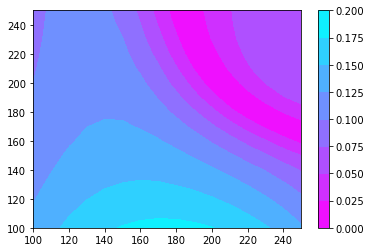

In [37]:
X = df2.index.to_numpy().flatten()
Y = df2.index.to_numpy().flatten()
x,y  = np.meshgrid(X,Y)
data = df2.to_numpy()
#===Plot===#
plt.subplot(111)
plt.contourf(x,y,data, cmap='cool_r')
plt.colorbar()
plt.show()

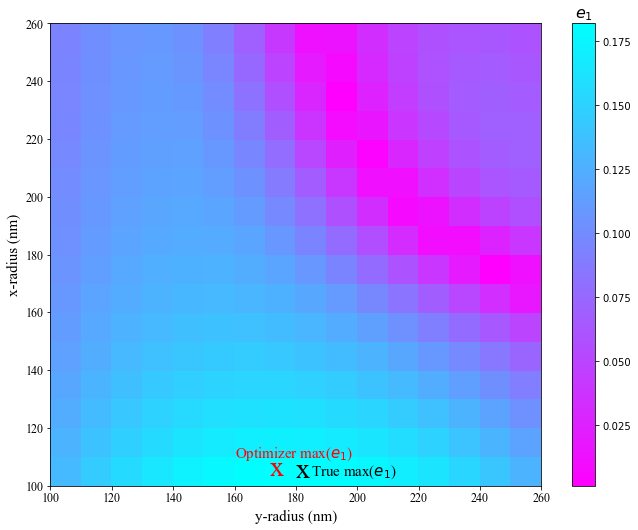

In [38]:
plt.pcolormesh(data, cmap='cool_r')
#plt.colorbar()
plt.xticks([0, 2, 4, 6, 8, 10, 12, 14, 16], ['100', '120', '140', '160', '180', '200', '220', '240', '260'])
plt.yticks([0, 2, 4, 6, 8, 10, 12, 14, 16], ['100', '120', '140', '160', '180', '200', '220', '240', '260'])

#plt.title('$e_1$ Values for Single Pillar Parameter Space', fontsize=20)
plt.xlabel('y-radius (nm)', fontsize=15, **tfont)
plt.ylabel('x-radius (nm)', fontsize=15, **tfont)
plt.text(7.15, 0.35, 'x', fontsize=28, color='r', **tfont)
plt.text(8, 0.3, 'x', fontsize=28, color='k', **tfont)
plt.text(6, 1, 'Optimizer max($e_1$)', fontsize = 15, color='r', **tfont)
plt.text(8.5, 0.35, 'True max($e_1$)', fontsize = 15, color='k', **tfont)
#plt.axis('equal')
plt.colorbar().ax.set_title('$e_1$', fontsize=16)

#plt.margins(x=0.005, tight=True)
plt.xticks(fontsize=12, **tfont)
plt.yticks(fontsize=12, **tfont)


plt.show
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(11, 8.5, forward=True)

plt.savefig('e1map-paper.png', format='png', bbox_inches='tight')

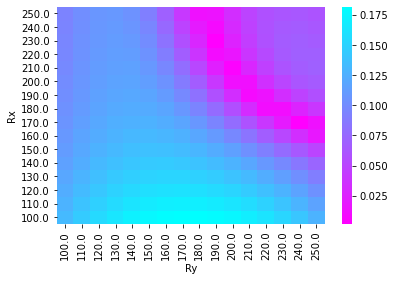

In [39]:
# Defining figure size  
# for the output plot 
#fig = plt.figure()
#ax = fig.add_subplot(111, aspect='equal')

Xlin = np.full(16, 100)
Ylin = np.full(16, 160)


#fig = plt.figure(figsize=(10, 10)) 
#ax.set_title("State probabilities")
#ax.set_xlabel("Time step")
#ax.set_ylabel("Hidden states")
#plt.plot(Xlin, Ylin, 'x', color='k')
#plt.show()



ax = sns.heatmap(df2, cmap ='cool_r')
ax.plot(Xlin, Ylin, marker='o')
ax.invert_yaxis()

#sns.scatterplot(, color='k')

In [40]:
ypos = np.array(np.loadtxt("basinarray_ypos.txt"))
e1phase = np.array(np.loadtxt("best_fit_array-ypos.txt", dtype = 'complex'))

In [41]:
(np.absolute(e1phase)/np.min(np.absolute(e1phase))-1)*100

array([0.        , 0.09547248, 0.21634566, 0.3282246 , 0.43764831,
       0.54601896, 0.65210846, 0.72437611, 0.78848866, 0.81013262,
       0.84695083, 0.83652127, 0.83704533, 0.79133479, 0.7344345 ,
       0.64878158, 0.54717778, 0.48599199, 0.3781067 , 0.25697195,
       0.15054984])

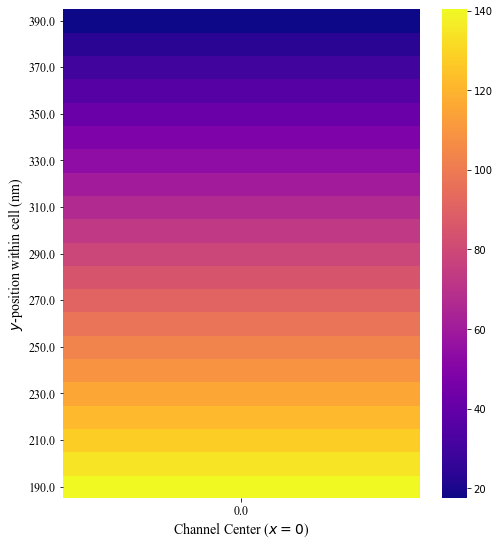

In [42]:
x = pd.DataFrame(np.zeros(len(e1phase)), columns = ['Rx'])
y = pd.DataFrame(np.round(ypos*1e9, 0), columns = ['ypos'])
z = pd.DataFrame(np.angle(e1phase, deg=True), columns = ['phase(e1)'])

df = pd.concat((pd.concat((x, y), axis=1), z), axis=1)
df2 = df.pivot(index="ypos", columns="Rx", values="phase(e1)")
df2

ax = sns.heatmap(df2, cmap='plasma')
ax.invert_yaxis()
ax.figure.axes[-1].yaxis.label.set_size(18)
#plt.title('Effect of $y$-position on Phase($e_1$)', fontsize=20)
plt.ylabel('$y$-position within cell (nm)', fontsize=14, **tfont)
plt.xlabel('Channel Center ($x=0$)', fontsize=14, **tfont)




#plt.margins(x=0.005, tight=True)
plt.xticks(fontsize=12, **tfont)
plt.yticks(fontsize=12, **tfont)

#plt.ylabel('Relative $e_1$ Value', fontsize=18)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 9, forward=True)

plt.savefig('phase-e1-paper.png', format='png', bbox_inches='tight')

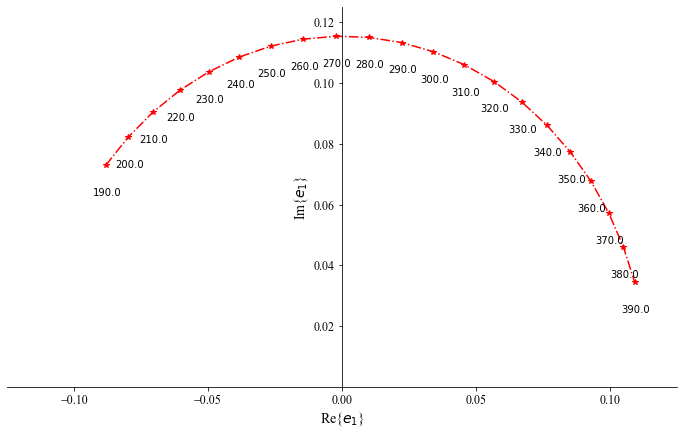

In [43]:
# extract real part using numpy
x = e1phase.real
# extract imaginary part using numpy
y = e1phase.imag





  
# plot the complex numbers
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(x, y, '-.r*', label='$y$-position (nm)')
# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')
#ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.ylabel('Im{$e_1$}', fontsize=14, **tfont)
plt.xlabel('Re{$e_1$}', fontsize=14, **tfont)
#plt.axis('equal')
plt.xlim([-0.125, 0.125])
plt.ylim([0.000001, 0.125])

plt.xticks(fontsize=12, **tfont)
plt.yticks(fontsize=12, **tfont)




# Loop for annotation of all points
for i in range(len(x)):
    plt.annotate(df['ypos'].loc[i], (x[i]-0.005, y[i] - 0.01))



#plt.title('Effect of $y$-position on $e_1$', fontsize=20)
#plt.xlabel('Distance ($\mu$m)', fontsize=18)
#plt.ylabel('Relative phase($e_1$) (rad)', fontsize=18)
#plt.legend(loc='lower right', fontsize=12)

#plt.ylabel('Relative $e_1$ Value', fontsize=18)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 7, forward=True)

plt.savefig('yposComplexPlot-paper.png', format='png', bbox_inches='tight')

In [38]:
multidf = pd.DataFrame(np.array(np.loadtxt("Final-multipillar-bestGvals-30per-1.txt")))
multiGdf = pd.DataFrame(np.array(np.loadtxt("retvalarray_multi-optimization.txt")))
multiParamdf = pd.DataFrame(np.array(np.loadtxt("basinarray_multi-optimization.txt")))
nonperdf = pd.DataFrame(np.array(np.loadtxt("Final-nonperiodic-bestGvals-50per-1.txt")))
nonperGdf = pd.DataFrame(np.array(np.loadtxt("retvalarray_nonperiodic-optimization.txt")))
nonperParamdf = pd.DataFrame(np.array(np.loadtxt("basinarray_nonperiodic-optimization.txt")))

In [39]:
Periods = 30 
H = 0
beta = 0.4 
beta_array = np.full((Periods,), beta) #array of electron velocity at each period
Periods_array = lml*beta_array #periodicity of each cell
max_Periods_array = Periods_array.copy()

a = np.linspace(0,2*np.pi,Periods)
z = (np.cos(a) + 1)/12
d_n =  np.reshape(z,(Periods,1)) 

#max_Periods_array = accel_calc(max_Periods_array, d_n.flatten()) #calculate the max_Periods from the design curve
FDTDxspan = 4.2e-6
FDTDyspan = np.sum(max_Periods_array)
FDTDdx = 10.0e-9
FDTDdy = 10.0e-9
yarrsize = math.ceil(max_Periods_array[-1]/FDTDdy) #max array size to interpolate all cells to, for numpy array operations
xarrsize = math.ceil(FDTDxspan/(2*FDTDdx)) + 1
cell_size = yarrsize//Periods
Xmax = np.linspace(0.0, FDTDxspan/2, xarrsize)
Ymax = np.linspace(0.0, FDTDyspan, yarrsize)
#max_Periods_array
FDTDyspan*1e6, W_array[0]/1000, W_array[-1]/W_array[0]

(23.184000000000005, 46.546709552960486, 1.0124021718710576)

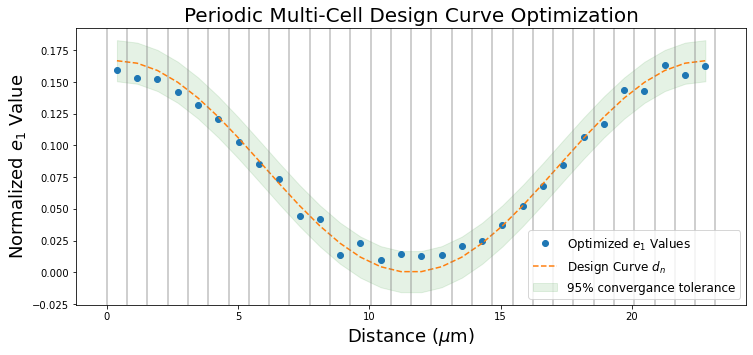

In [40]:
B = multiParamdf.loc[multiGdf.idxmin()]
X = B[B.columns[2::3]].to_numpy().flatten()*1e6
Y = multidf.to_numpy().flatten()


plt.plot(X[H:Periods-H], Y[H:Periods-H], 'o', label='Optimized $e_1$ Values')
plt.plot(X[H:Periods-H], d_n[H:Periods-H], ls='--', label='Design Curve $d_n$')
for j in range(Periods+1):
    plt.axvline(x=j*lml*beta*1e6, ymax=1, color='grey', alpha=0.5, ls='-')


plt.title('Periodic Multi-Cell Design Curve Optimization', fontsize=20)
plt.xlabel('Distance ($\mu$m)', fontsize=18)
plt.ylabel('Normalized $e_1$ Value', fontsize=18)
plt.fill_between(X[H:Periods-H], d_n[H:Periods-H].flatten()-np.round((5.1*maxe1array[maxbetaarray==beta])/100, 4),
                 d_n[H:Periods-H].flatten()+np.round((5.1*maxe1array[maxbetaarray==beta])/100, 4), alpha=0.1,
                 label='95% convergance tolerance', color='g')
plt.legend(loc='lower right', fontsize=12)


fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 5.1, forward=True)

plt.savefig('Pmulticell.pdf', format='pdf', bbox_inches='tight')

In [41]:
Periods = 50 
H = 0
L = 10
beta = 0.4 
betaratio = np.ones(Periods)
beta_array = np.full((Periods,), beta) #array of electron velocity at each period
Periods_array = lml*beta_array #periodicity of each cell
max_Periods_array = Periods_array.copy()

a = np.linspace(0,np.pi,Periods)
z = (np.sin(a) + 1)/12
d_n =  np.reshape(z,(Periods,1)) 

max_Periods_array = accel_calc(max_Periods_array, d_n.flatten()) #calculate the max_Periods from the design curve
FDTDxspan = 4.2e-6
FDTDyspan = np.sum(max_Periods_array)
FDTDdx = 10.0e-9
FDTDdy = 10.0e-9
yarrsize = math.ceil(max_Periods_array[-1]/FDTDdy) #max array size to interpolate all cells to, for numpy array operations
xarrsize = math.ceil(FDTDxspan/(2*FDTDdx)) + 1
cell_size = yarrsize//Periods
Xmax = np.linspace(0.0, FDTDxspan/2, xarrsize)
Ymax = np.linspace(0.0, FDTDyspan, yarrsize)
#max_Periods_array
FDTDyspan*1e6, W_array[0]/1000, W_array[-1]/W_array[0]

(38.733115274864815, 46.546709552960486, 1.011120240916702)

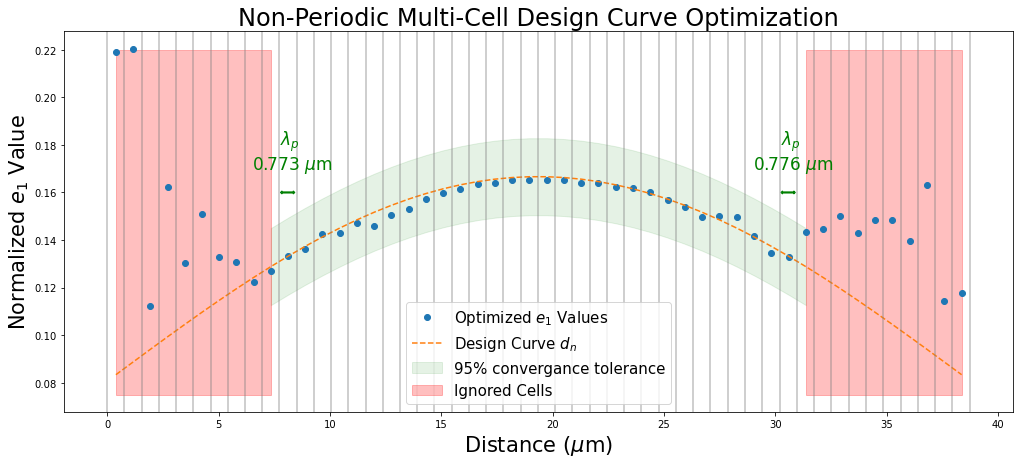

In [42]:
B = nonperParamdf.loc[nonperGdf.idxmin()]
X = B[B.columns[2::3]].to_numpy().flatten()*1e6#*betaratio
Y = nonperdf.to_numpy().flatten()


plt.plot(X[H:Periods-H], Y[H:Periods-H], 'o', label='Optimized $e_1$ Values')
plt.plot(X[H:Periods-H], d_n[H:Periods-H], ls='--', label='Design Curve $d_n$')
for j in range(H-1, Periods-H):
    plt.axvline(x=np.sum(max_Periods_array[:j+1])*1e6, ymax=1, color='grey', alpha=0.5, ls='-')

plt.title('Non-Periodic Multi-Cell Design Curve Optimization', fontsize=24)
plt.xlabel('Distance ($\mu$m)', fontsize=21)
plt.ylabel('Normalized $e_1$ Value', fontsize=21)

plt.text(7.75, 0.18, '$\lambda_p$', fontsize = 17, color='g')
plt.arrow(7.85, 0.16, 0.5, 0, ec ='green', head_length=0.075, head_width=0.0013, width=0.0003)
plt.arrow(8.35, 0.16, -0.5, 0, ec ='green', head_length=0.075, head_width=0.0013, width=0.0003)
plt.text(6.5, 0.17, '0.773 $\mu$m', fontsize = 17, color='g')
#plt.text(7.655, 0.159, '(nm)', fontsize = 15, color='g')

plt.text(30.25, 0.18, '$\lambda_p$', fontsize = 17, color='g')
plt.arrow(30.33, 0.16, 0.5, 0, ec ='green', head_length=0.075, head_width=0.0013, width=0.0003)
plt.arrow(30.83, 0.16, -0.5, 0, ec ='green', head_length=0.075, head_width=0.0013, width=0.0003)
plt.text(29, 0.17, '0.776 $\mu$m', fontsize = 17, color='g')
#plt.text(30.135, 0.15, '(nm)', fontsize = 15, color='g')

plt.fill_between(X[L-1:Periods-L+1], d_n[L-1:Periods-L+1].flatten()-np.round((5.1*maxe1array[maxbetaarray==beta])/100, 4),
                 d_n[L-1:Periods-L+1].flatten()+np.round((5.1*maxe1array[maxbetaarray==beta])/100, 4), alpha=0.1,
                 label='95% convergance tolerance', color='g')
plt.fill_between(X[:L], 0.075, 0.22, alpha=0.25, color='r', label='Ignored Cells')
plt.fill_between(X[-L:], 0.075, 0.22, alpha=0.25, color='r')


plt.legend(loc='lower center', fontsize=15)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(17, 7, forward=True)

plt.savefig('NPmulticell.pdf', format='pdf', bbox_inches='tight')

In [43]:
A = np.array([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8])
B = np.array([0.02997519, 0.08826858, 0.14586067, 0.18895123, 0.21824774, 0.23316292, 0.31697082, 0.43405189, 0.54406427, 0.76910321, 0.79951867, 0.85867393, 0.85867138, 0.81988915, 0.80016179 ])

In [44]:
x = A[2:-2]
y = B[2:-2]

kernel_size = 3
kernel = np.ones(kernel_size) / kernel_size
y_conv = np.convolve(y.flatten(), kernel, mode='same')
y_conv[0] = np.sum(y[:2])/2
y_conv[-1] = np.sum(y[-2:])/2
y = y_conv.copy()
y

array([0.16740595, 0.18435321, 0.21345396, 0.25612716, 0.32806188,
       0.43169566, 0.58240646, 0.70422872, 0.8090986 , 0.83895466,
       0.85867266])

funcion coefficients:
[ 0.1681616   0.71904549 15.87927686  0.48068445]
Covariance of coefficients:
[[ 5.96392072e-05 -9.35300876e-05  4.28576887e-03  6.81248350e-06]
 [-9.35300876e-05  2.40991625e-04 -1.07332565e-02  1.32200045e-05]
 [ 4.28576887e-03 -1.07332565e-02  6.42978991e-01 -5.29962609e-04]
 [ 6.81248350e-06  1.32200045e-05 -5.29962609e-04  1.01042005e-05]]


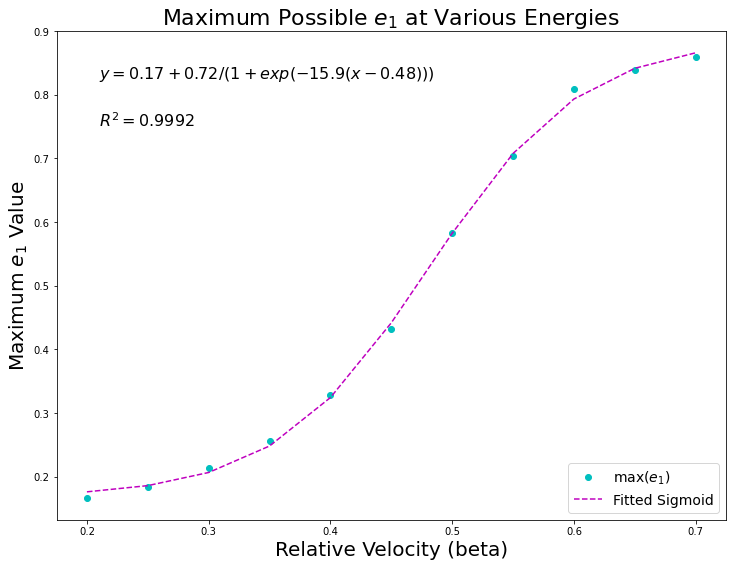

In [45]:
def model(x, a, b, c, d): 
    return a*x**3 + b*x**2 + c*x + d
def model_sigmoid(x, a, b, c, d):
    return a + b/(1+np.exp(-c*(x-d)))
  
# curve_fit() function takes the test-function 
# x-data and y-data as argument and returns  
# the coefficients a and b in param and 
# the estimated covariance of param in param_cov 
param, param_cov = curve_fit(model_sigmoid, x, y) 
  
print("funcion coefficients:") 
print(param) 
print("Covariance of coefficients:") 
print(param_cov) 

residuals = y-model_sigmoid(x, param[0], param[1], param[2], param[3])
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
#print(r_squared)


  
# ans stores the new y-data according to  
# the coefficients given by curve-fit() function 
#ans = param[0]*x**3+param[1]*x**2 +param[2]*x +param[3]
ans =  param[0] + param[1]/(1+np.exp(-param[2]*(x-param[3])))


#slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
#print('S = ', slope, 'intercept = ', intercept, 'r^2 = ',  r_value**2, 'error = ', std_err)


plt.plot(x, y, 'o', label='max($e_1$)', color='c')
plt.plot(x, ans, label='Fitted Sigmoid', color='m', ls='--')

plt.title('Maximum Possible $e_1$ at Various Energies', fontsize=22)
plt.xlabel('Relative Velocity (beta)', fontsize=20)
plt.ylabel('Maximum $e_1$ Value', fontsize=20)

plt.legend(loc='lower right', fontsize=14)
plt.text(0.21, 0.75, '$R^2=${r:.4f}'.format(r = r_squared), fontsize=16)
plt.text(0.21, 0.825, '$y = 0.17 + 0.72/(1+exp(-15.9(x-0.48)))$', fontsize=16)


fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 9, forward=True)
plt.savefig('e1betacurve.pdf', format='pdf', bbox_inches='tight')